In [1]:
import warnings

warnings.filterwarnings("ignore")

import math
from math import sqrt

import LESS_main.less.less_reductions as ls
import LESS_main.less.less_reweighing as lsr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from fairlearn import preprocessing, reductions
from fairlearn.metrics import MetricFrame, count, selection_rate
from fairlearn.reductions import (
    BoundedGroupLoss,
    DemographicParity,
    ErrorRate,
    GridSearch,
    SquareLoss,
    ZeroOneLoss,
)
from LESS_main.less.less import LESSRegressor
from scipy.stats import kde
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from tqdm import tqdm

from fair_dummies import fair_dummies_learning, utility_functions

seed = 123

# Student Performance dataset

In [2]:
# Importing student performance dataset
df1 = pd.read_csv("student-mat.csv", delimiter=";")
df2 = pd.read_csv("student-por.csv", delimiter=";")

df = pd.concat([df1, df2])
df = df[
    [
        "G3",
        "G2",
        "G1",
        "sex",
        "failures",
        "higher",
        "Medu",
        "school",
        "studytime",
        "Fedu",
    ]
]

In [3]:
# Creating dummies for sensitive attribute, higher education and school variables
female = pd.get_dummies(df["sex"])
higher_education = pd.get_dummies(df["higher"])
school_GP = pd.get_dummies(df["higher"])

df = pd.concat([df, female, higher_education], axis="columns")
df = df.drop(["higher", "no", "sex", "M"], axis=1)
df = df.rename(columns={"F": "female", "yes": "higher"})

df = pd.concat([df, school_GP], axis="columns")
df = df.drop(["school", "no"], axis=1)
df = df.rename(columns={"yes": "school_GP"})

df.head()

,G3,G2,G1,failures,Medu,studytime,Fedu,female,higher,school_GP
0,6,6,5,0,4,2,4,1,1,1
1,6,5,5,0,1,2,1,1,1,1
2,10,8,7,3,1,2,1,1,1,1
3,15,14,15,0,4,3,2,1,1,1
4,10,10,6,0,3,2,3,1,1,1


In [4]:
# Establishing dependent and independent variables
X = list(df.columns)
Y = X[len(X) - 10]

del X[len(X) - 10]
Y, X

train_df = df.dropna()

In [5]:
# Generating train-test split
X_train, X_test, y_train, y_test = train_test_split(
    train_df[X], train_df[Y], test_size=0.3, random_state=seed
)

In [6]:
X_train = X_train[["female"] + [col for col in X_train.columns if col != "female"]]
X_test = X_test[["female"] + [col for col in X_test.columns if col != "female"]]
X_train.head()

,female,G2,G1,failures,Medu,studytime,Fedu,higher,school_GP
299,0,15,16,0,4,1,4,1,1
313,1,13,13,0,1,2,1,1,1
320,1,12,14,1,4,2,4,1,1
434,1,9,10,0,2,4,2,0,0
63,1,13,14,0,4,3,3,1,1


## Baseline Model Training

### Linear Regression Baseline

In [7]:
linreg_baseline = LinearRegression()
linreg_baseline.fit(X_train, y_train)
y_linreg_baseline_pred = linreg_baseline.predict(X_test)

### LESS Baseline

In [8]:
LESS_model = LESSRegressor(frac=0.2, random_state=seed)
LESS_model.fit(X_train, y_train)
y_pred_baseline = LESS_model.predict(X_test)

100%|██████████| 20/20 [00:00<00:00, 99.94it/s]


## Correlation Remover

In [9]:
# Object used to remove correlation
correlation_remover_train = preprocessing.CorrelationRemover(
    sensitive_feature_ids=["female"]
)
correlation_remover_train.fit(X_train, y_train)

# Removing correlation from our training set
X_train_uncorr = correlation_remover_train.transform(X_train)
X_train_uncorr_wr = np.concatenate(
    (np.array(X_train["female"]).reshape(-1, 1), X_train_uncorr), axis=1
)

### Linear Regression with Correlation Remover

In [10]:
linreg_uncorr = LinearRegression()
linreg_uncorr.fit(X_train_uncorr_wr, y_train)
y_linreg_uncorr_pred = linreg_uncorr.predict(X_test)

### LESS with Correlation Remover

In [11]:
LESS_model_uncorr_wr = LESSRegressor(frac=0.2, random_state=seed)
LESS_model_uncorr_wr.fit(X_train_uncorr_wr, y_train)
y_pred_uncorr_wr = LESS_model_uncorr_wr.predict(X_test)

100%|██████████| 20/20 [00:00<00:00, 68.66it/s]


## Discretisation and Reweighting

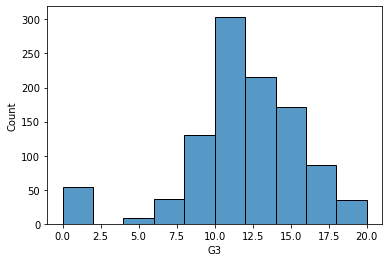

In [12]:
# Distribution of outcome variable
sns.histplot(df[Y], kde=False, bins=10)
plt.show()

In [13]:
# Generating a column for outcome class
est = KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="uniform")
Y_np = train_df[Y].to_numpy().reshape(-1, 1)
est.fit(Y_np)
df_Yt = est.transform(Y_np)

df_rw = train_df.copy()
df_rw["grade class"] = df_Yt.reshape(-1)
df_rw.head()

,G3,G2,G1,failures,Medu,studytime,Fedu,female,higher,school_GP,grade class
0,6,6,5,0,4,2,4,1,1,1,3.0
1,6,5,5,0,1,2,1,1,1,1,3.0
2,10,8,7,3,1,2,1,1,1,1,5.0
3,15,14,15,0,4,3,2,1,1,1,7.0
4,10,10,6,0,3,2,3,1,1,1,5.0


In [14]:
# Establishing dependent and independent variables
columns = list(df_rw.columns)
y_rw = df_rw[columns[0]]
del columns[0]
X_rw = df_rw[columns]

# Generating train-test split
X_train_rw, X_test_rw, y_train_rw, y_test_rw = train_test_split(
    X_rw, y_rw, test_size=0.3, random_state=seed
)

In [15]:
# Lists of sensitive attribute values and outcome classes
sensitive = list(X_train_rw["female"].unique())
label = list(X_train_rw["grade class"].unique())

In [16]:
# Calculating weights for each combination of sensitive attribute value
# and outcome class using Kamiran-Calders algorithm
weights = {}
for i in tqdm(sensitive):
    for j in label:
        if (
            len(X_train_rw)
            * len(
                X_train_rw[
                    (X_train_rw["female"] == i) & (X_train_rw["grade class"] == j)
                ]
            )
        ) == 0:
            weights[(i, j)] = 0
        else:
            weights[(i, j)] = (
                len(X_train_rw[X_train_rw["female"] == i])
                * len(X_train_rw[X_train_rw["grade class"] == j])
            ) / (
                len(X_train_rw)
                * len(
                    X_train_rw[
                        (X_train_rw["female"] == i) & (X_train_rw["grade class"] == j)
                    ]
                )
            )

100%|██████████| 2/2 [00:00<00:00, 43.51it/s]


In [17]:
# Creating new column for sample weights
def get_weights(a, b):
    return weights[(a, b)]


X_train_rw["weights"] = X_train_rw.apply(
    lambda x: get_weights(x["female"], x["grade class"]), axis=1
)

### Reweighing with Linear Regression

In [18]:
linreg_rw = LinearRegression()
linreg_rw.fit(X_train_rw[X], y_train_rw, X_train_rw["weights"])
y_linreg_pred_rw = linreg_rw.predict(X_test_rw[X])

### Reweighing with LESS

In [19]:
LESS_model_rw = lsr.LESSRegressor(frac=0.2, random_state=seed)
LESS_model_rw.fit(X_train_rw[X], y_train_rw, X_train_rw["weights"])
y_pred_rw = LESS_model_rw.predict(X_test_rw[X])

### Hyperparameter Tuning for Reweighing (strategies and number of bins)

In [20]:
Y_np = train_df[Y].to_numpy().reshape(-1, 1)
y_rw = train_df[Y]
X_rw = train_df[X]
# List of bin numbers to try
bins = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# List of two binning strategies to try
strategies = ["uniform", "quantile"]
weights = {}

df_predictions_weights = pd.DataFrame(
    {"Actual": y_test, "Sensitive Attribute": X_test["female"],}
)


def get_weights(a, b):
    return weights[(a, b)]


for s in strategies:
    for b in bins:
        est = KBinsDiscretizer(n_bins=b, encode="ordinal", strategy=s)
        est.fit(Y_np)
        df_Yt = est.transform(Y_np)
        X_rw["grade class"] = df_Yt.reshape(-1)

        X_train_rw, X_test_rw, y_train_rw, y_test_rw = train_test_split(
            X_rw, y_rw, test_size=0.3, random_state=seed
        )

        sensitive = list(X_train_rw["female"].unique())
        label = list(X_train_rw["grade class"].unique())
        sensitive, label

        weights = {}
        for i in sensitive:
            for j in label:
                if (
                    len(X_train_rw)
                    * len(
                        X_train_rw[
                            (X_train_rw["female"] == i)
                            & (X_train_rw["grade class"] == j)
                        ]
                    )
                ) == 0:
                    weights[(i, j)] = 0
                else:
                    weights[(i, j)] = (
                        len(X_train_rw[X_train_rw["female"] == i])
                        * len(X_train_rw[X_train_rw["grade class"] == j])
                    ) / (
                        len(X_train_rw)
                        * len(
                            X_train_rw[
                                (X_train_rw["female"] == i)
                                & (X_train_rw["grade class"] == j)
                            ]
                        )
                    )

        X_train_rw["weights"] = X_train_rw.apply(
            lambda x: get_weights(x["female"], x["grade class"]), axis=1,
        )

        # Fitting model with sample weights associated with given combination
        # of bin number and binning strategy
        LESS_model_rw = lsr.LESSRegressor(frac=0.2, random_state=seed)
        LESS_model_rw.fit(X_train_rw[X], y_train_rw, X_train_rw["weights"])
        y_pred_rw = LESS_model_rw.predict(X_test_rw[X])

        # Evaluating accuracy and fairness
        df_predictions_weights["Predicted"] = y_pred_rw
        df_predictions_weights = df_predictions_weights.reset_index(drop=True)
        df_predictions_weights_zero = df_predictions_weights[
            df_predictions_weights["Sensitive Attribute"] == 0
        ]
        df_predictions_weights_one = df_predictions_weights[
            df_predictions_weights["Sensitive Attribute"] == 1
        ]

        print(
            "Test error of LESS with "
            + str(b)
            + " bins, using "
            + s
            + " strategy: {0:.4f}".format(
                math.sqrt(
                    mean_squared_error(
                        df_predictions_weights["Predicted"],
                        df_predictions_weights["Actual"],
                    )
                )
            )
        )
        print(
            "Group RMSE ratio using LESS with "
            + str(b)
            + " bins, using "
            + s
            + " strategy: {0:.4f}".format(
                math.sqrt(
                    mean_squared_error(
                        df_predictions_weights_one["Predicted"],
                        df_predictions_weights_one["Actual"],
                    )
                )
                / math.sqrt(
                    mean_squared_error(
                        df_predictions_weights_zero["Predicted"],
                        df_predictions_weights_zero["Actual"],
                    )
                )
            )
        )
        print(
            "Group ME difference of LESS with "
            + str(b)
            + " bins, using "
            + s
            + " strategy: {0:.4f}".format(
                (
                    df_predictions_weights_one["Predicted"]
                    - df_predictions_weights_one["Actual"]
                ).mean()
                - (
                    df_predictions_weights_zero["Predicted"]
                    - df_predictions_weights_zero["Actual"]
                ).mean()
            )
        )
    print("-----------------------------------------------------")

Test error of LESS with 2 bins, using uniform strategy: 1.4687
Group RMSE ratio using LESS with 2 bins, using uniform strategy: 1.2246
Group ME difference of LESS with 2 bins, using uniform strategy: 0.0747
Test error of LESS with 3 bins, using uniform strategy: 1.4696
Group RMSE ratio using LESS with 3 bins, using uniform strategy: 1.2268
Group ME difference of LESS with 3 bins, using uniform strategy: 0.0793
Test error of LESS with 4 bins, using uniform strategy: 1.4690
Group RMSE ratio using LESS with 4 bins, using uniform strategy: 1.2256
Group ME difference of LESS with 4 bins, using uniform strategy: 0.0807
Test error of LESS with 5 bins, using uniform strategy: 1.4664
Group RMSE ratio using LESS with 5 bins, using uniform strategy: 1.2225
Group ME difference of LESS with 5 bins, using uniform strategy: 0.0835
Test error of LESS with 6 bins, using uniform strategy: 1.4698
Group RMSE ratio using LESS with 6 bins, using uniform strategy: 1.2269
Group ME difference of LESS with 6 bi

## Fair Dummies Training (Romano) 

### Parameter Selection (From Romano paper)

### Fair Dummies LESS

In [21]:
# Fair Dummies hyperparameters
in_shape = X_train.shape[1] - 1
batch_size = 10000
lr_loss = 0.01
lr_dis = 0.01
loss_steps = 80
dis_steps = 80
mu_val = 0.7
second_scale = 1
epochs = 20
cost_pred = torch.nn.MSELoss()
model_type = "linear_model"

# Fitting model
loc_est = lambda: fair_dummies_learning.EquiRegLearner(
    lr=lr_loss,
    pretrain_pred_epochs=0,
    pretrain_dis_epochs=0,
    epochs=epochs,
    loss_steps=loss_steps,
    dis_steps=dis_steps,
    cost_pred=cost_pred,
    in_shape=in_shape,
    batch_size=batch_size,
    model_type=model_type,
    lambda_vec=mu_val,
    second_moment_scaling=second_scale,
    out_shape=1,
)

LESS_model_equireg = LESSRegressor(
    local_estimator=loc_est, frac=0.2, equireg=True, random_state=seed
)
LESS_model_equireg.fit(np.array(X_train), y_train)

100%|██████████| 20/20 [12:03<00:00, 36.16s/it]


LESSRegressor(equireg=True, frac=0.2,
              local_estimator=<function <lambda> at 0x0000023415E41CA0>,
              n_neighbors=146, n_subsets=5, random_state=123)

In [22]:
dummies_pred = LESS_model_equireg.predict(np.array(X_test))
print("Test error of LESS: {0:.4f}".format(mean_squared_error(dummies_pred, y_test)))
df_predictions_fair_dummies = pd.DataFrame(
    {"Actual": y_test, "Sensitive Attribute": X_test["female"],}
)
df_predictions_fair_dummies["Predicted"] = dummies_pred
df_predictions_fair_dummies = df_predictions_fair_dummies.reset_index(drop=True)
df_predictions_fair_dummies_zero = df_predictions_fair_dummies[
    df_predictions_fair_dummies["Sensitive Attribute"] == 0
]
df_predictions_fair_dummies_one = df_predictions_fair_dummies[
    df_predictions_fair_dummies["Sensitive Attribute"] == 1
]
print(
    "Test error of Fair Dummies: {0:.4f}".format(
        mean_squared_error(
            df_predictions_fair_dummies["Predicted"],
            df_predictions_fair_dummies["Actual"],
        )
    )
)
print(
    "Group MSE Difference Fair Dummies: {0:.4f}".format(
        mean_squared_error(
            df_predictions_fair_dummies_one["Predicted"],
            df_predictions_fair_dummies_one["Actual"],
        )
        - mean_squared_error(
            df_predictions_fair_dummies_zero["Predicted"],
            df_predictions_fair_dummies_zero["Actual"],
        )
    )
)
print(
    "Group ME Difference Fair Dummies: {0:.4f}".format(
        (
            df_predictions_fair_dummies_one["Predicted"]
            - df_predictions_fair_dummies_one["Actual"]
        ).mean()
        - (
            df_predictions_fair_dummies_zero["Predicted"]
            - df_predictions_fair_dummies_zero["Actual"]
        ).mean()
    )
)

Test error of LESS: 2.1524
Test error of Fair Dummies: 2.1524
Group MSE Difference Fair Dummies: 0.8478
Group ME Difference Fair Dummies: 0.0090


### Linear Regression Fair Dummies

In [23]:
FD_model = fair_dummies_learning.EquiRegLearner(
    lr=lr_loss,
    pretrain_pred_epochs=0,
    pretrain_dis_epochs=0,
    epochs=epochs,
    loss_steps=loss_steps,
    dis_steps=dis_steps,
    cost_pred=cost_pred,
    in_shape=in_shape,
    batch_size=batch_size,
    model_type=model_type,
    lambda_vec=mu_val,
    second_moment_scaling=second_scale,
    out_shape=1,
)

FD_model.fit(np.array(X_train), y_train)

Lin_reg_FD_pred = FD_model.predict(np.array(X_test))

### Uncorrelated Variables with Fair Dummies

In [24]:
LESS_model_equireg_uncorr = LESSRegressor(
    local_estimator=loc_est, frac=0.2, equireg=True, random_state=seed
)
LESS_model_equireg_uncorr.fit(X_train_uncorr_wr, y_train)
dummies_uncorr_pred = LESS_model_equireg_uncorr.predict(np.array(X_test))

100%|██████████| 20/20 [11:00<00:00, 33.02s/it]


 ### Uncorrelated with Fair Dummies Linear Regression   

In [25]:
FD_model_uncorr = fair_dummies_learning.EquiRegLearner(
    lr=lr_loss,
    pretrain_pred_epochs=0,
    pretrain_dis_epochs=0,
    epochs=epochs,
    loss_steps=loss_steps,
    dis_steps=dis_steps,
    cost_pred=cost_pred,
    in_shape=in_shape,
    batch_size=batch_size,
    model_type=model_type,
    lambda_vec=mu_val,
    second_moment_scaling=second_scale,
    out_shape=1,
)

FD_model_uncorr.fit(np.array(X_train_uncorr_wr), y_train)

Lin_reg_FD_uncorr_pred = FD_model_uncorr.predict(np.array(X_test))

## Bounded Group Loss(Agarwal)

### Bounded group loss model

In [26]:
# Defining bounded group loss constraint
bgl1 = BoundedGroupLoss(SquareLoss(0, 1), upper_bound=0.05)

# Fitting model
reduction = GridSearch(LinearRegression(), constraints=bgl1, grid_size=100)
reduction.fit(
    X_train[X].drop("female", axis=1), y_train, sensitive_features=X_train["female"],
)
y_pred_BGL_only = reduction.predict(X_test[X].drop("female", axis=1))

### LESS with BGL

In [27]:
df_predictions_LESS_BGL_tuned = pd.DataFrame(
    {"Actual": y_test, "Sensitive Attribute": X_test["female"],}
)

LESS_model_BGL_tuned = ls.LESSRegressor(frac=0.2, random_state=seed)
LESS_model_BGL_tuned.fit(X_train, y_train, "female", gridsize=100)
y_pred_BGL_LESS_tuned = LESS_model_BGL_tuned.predict(X_test)

100%|██████████| 20/20 [03:21<00:00, 10.09s/it]


### Hyperparameter Tuning: Grid size and Upper bound

In [28]:
# List of grid sizes to try
gridsize = [25, 50, 100, 200, 500]
df_predictions_gridsizes = pd.DataFrame(
    {"Actual": y_test, "Sensitive Attribute": X_test["female"],}
)

for g in gridsize:
    LESS_model_BGL = ls.LESSRegressor(frac=0.2, random_state=seed)
    LESS_model_BGL.fit(X_train, y_train, "female", gridsize=g)
    y_pred_BGL_LESS = LESS_model_BGL.predict(X_test)

    df_predictions_gridsizes["Predicted"] = y_pred_BGL_LESS
    df_predictions_gridsizes = df_predictions_gridsizes.reset_index(drop=True)
    df_predictions_gridsizes_zero = df_predictions_gridsizes[
        df_predictions_gridsizes["Sensitive Attribute"] == 0
    ]
    df_predictions_gridsizes_one = df_predictions_gridsizes[
        df_predictions_gridsizes["Sensitive Attribute"] == 1
    ]

    print(
        "Test error of LESS with gridsize "
        + str(g)
        + ": {0:.4f}".format(
            math.sqrt(
                mean_squared_error(
                    df_predictions_gridsizes["Predicted"],
                    df_predictions_gridsizes["Actual"],
                )
            )
        )
    )
    print(
        "Group RMSE ratio LESS with gridsize "
        + str(g)
        + ": {0:.4f}".format(
            math.sqrt(
                mean_squared_error(
                    df_predictions_gridsizes_one["Predicted"],
                    df_predictions_gridsizes_one["Actual"],
                )
            )
            / math.sqrt(
                mean_squared_error(
                    df_predictions_gridsizes_zero["Predicted"],
                    df_predictions_gridsizes_zero["Actual"],
                )
            )
        )
    )
    print(
        "Group ME Difference LESS with gridsize "
        + str(g)
        + ": {0:.4f}".format(
            (
                df_predictions_gridsizes_one["Predicted"]
                - df_predictions_gridsizes_one["Actual"]
            ).mean()
            - (
                df_predictions_gridsizes_zero["Predicted"]
                - df_predictions_gridsizes_zero["Actual"]
            ).mean()
        )
    )

100%|██████████| 20/20 [00:50<00:00,  2.55s/it]


Test error of LESS with gridsize 25: 1.4729
Group RMSE ratio LESS with gridsize 25: 1.2184
Group ME Difference LESS with gridsize 25: 0.0997


100%|██████████| 20/20 [01:39<00:00,  4.99s/it]


Test error of LESS with gridsize 50: 1.4767
Group RMSE ratio LESS with gridsize 50: 1.2079
Group ME Difference LESS with gridsize 50: 0.1597


100%|██████████| 20/20 [03:38<00:00, 10.93s/it]


Test error of LESS with gridsize 100: 1.4728
Group RMSE ratio LESS with gridsize 100: 1.2184
Group ME Difference LESS with gridsize 100: 0.0992


100%|██████████| 20/20 [07:04<00:00, 21.25s/it]


Test error of LESS with gridsize 200: 1.4725
Group RMSE ratio LESS with gridsize 200: 1.2186
Group ME Difference LESS with gridsize 200: 0.0988


100%|██████████| 20/20 [17:07<00:00, 51.35s/it]

Test error of LESS with gridsize 500: 1.4769
Group RMSE ratio LESS with gridsize 500: 1.2075
Group ME Difference LESS with gridsize 500: 0.1603


### Bounded Group Loss with Uncorrelated variables

In [29]:
# Defining bounded group loss constraint
bgl_uncorr = BoundedGroupLoss(SquareLoss(0, 1), upper_bound=0.05)

# Fitting model
reduction_uncorr = GridSearch(LinearRegression(), constraints=bgl_uncorr, grid_size=100)
reduction_uncorr.fit(
    X_train_uncorr, y_train, sensitive_features=X_train["female"],
)
y_pred_BGL_uncorr = reduction_uncorr.predict(X_test[X].drop("female", axis=1))

### LESS with Bounded Group Loss and Uncorrelated Variables

In [ ]:
LESS_model_BGL_uncorr = ls.LESSRegressor(frac=0.2, random_state=seed)
LESS_model_BGL_uncorr.fit(
    pd.DataFrame(X_train_uncorr_wr, columns=X), y_train, "female", gridsize=100
)
y_pred_BGL_LESS_uncorr = LESS_model_BGL_uncorr.predict(X_test)

# Results and Plotting

In [31]:
# Creating dataframe of prediction series for each model
df_predictions = pd.DataFrame(
    {
        "Baseline_Less": y_pred_baseline,
        "Baseline_Lin_reg": y_linreg_baseline_pred,
        "Uncorrelated_LESS": y_pred_uncorr_wr,
        "Uncorrelated_Lin_Reg": y_linreg_uncorr_pred,
        "Dummies_LESS": dummies_pred,
        "Dummies_Lin_Reg": Lin_reg_FD_pred,
        "BGL": y_pred_BGL_only,
        "BGL_LESS": y_pred_BGL_LESS_tuned,
        "BGL_uncorr": y_pred_BGL_uncorr,
        "BGL_LESS_uncorr": y_pred_BGL_LESS_uncorr,
        "Reweigh_LESS": y_pred_rw,
        "Reweigh_Lin_Reg": y_linreg_pred_rw,
        "FD_Uncorr_LESS": dummies_uncorr_pred,
        "FD_Uncorr_Lin_Reg": Lin_reg_FD_uncorr_pred,
        "Actual": y_test,
        "Sensitive Attribute": X_test["female"],
    }
)
df_predictions = df_predictions.reset_index(drop=True)
df_predictions.head()

,Baseline_Less,Baseline_Lin_reg,Uncorrelated_LESS,Uncorrelated_Lin_Reg,Dummies_LESS,Dummies_Lin_Reg,BGL,BGL_LESS,BGL_uncorr,BGL_LESS_uncorr,Reweigh_LESS,Reweigh_Lin_Reg,FD_Uncorr_LESS,FD_Uncorr_Lin_Reg,Actual,Sensitive Attribute
0,11.271497,11.358529,11.360151,11.489970,11.260111,10.884123,11.429788,11.380411,11.429788,11.506437,11.226452,11.354096,11.412391,10.758425,12,1
1,7.838327,7.864947,7.733972,7.692743,7.859460,7.908522,8.004008,7.751099,8.004008,7.607054,7.880846,7.877206,7.859473,8.100235,11,0
2,14.413565,14.478702,14.553810,14.610143,14.372295,14.444835,14.504361,14.422396,14.504361,14.526050,14.397098,14.464705,14.361677,14.284759,15,1
3,10.112742,9.844741,10.215498,9.976182,10.093438,9.850838,9.969101,10.146910,9.969101,9.978219,10.080496,9.840984,10.042820,10.144731,11,1
4,13.351525,13.346527,13.488716,13.477967,13.327041,13.354614,13.330122,13.406753,13.330122,13.443130,13.359576,13.329488,13.297095,13.218925,13,1


In [32]:
# Splitting dataframe based on value of sensitive attribute
df_predictions_zero = df_predictions[df_predictions["Sensitive Attribute"] == 0]
df_predictions_one = df_predictions[df_predictions["Sensitive Attribute"] == 1]

In [33]:
# Creating dataframe of accuracy and fairness score results for each model
Results = pd.DataFrame()
cols = df_predictions.columns
cols = cols[:-2]
MSE = []
MED = []
RMSERBG = []

for col in cols:
    MSE.append(mean_squared_error(df_predictions[col], df_predictions["Actual"]))
    MED.append(
        (df_predictions_one[col] - df_predictions_one["Actual"]).mean()
        - (df_predictions_zero[col] - df_predictions_zero["Actual"]).mean()
    )
    RMSERBG.append(
        math.sqrt(
            mean_squared_error(df_predictions_one[col], df_predictions_one["Actual"])
        )
        / math.sqrt(
            mean_squared_error(df_predictions_zero[col], df_predictions_zero["Actual"])
        )
    )

Results = pd.DataFrame(
    {
        "Models": cols,
        "Mean Squared Error": MSE,
        "Mean Errors difference between groups": MED,
        "Root-mean-squared error ratio between groups": RMSERBG,
    }
)

Results["Root Mean Squared Error"] = Results["Mean Squared Error"].apply(
    lambda x: math.sqrt(x)
)
Results

,Models,Mean Squared Error,Mean Errors difference between groups,Root-mean-squared error ratio between groups,Root Mean Squared Error
0,Baseline_Less,2.159247,0.103367,1.223036,1.469437
1,Baseline_Lin_reg,2.215556,0.079746,1.226799,1.488474
2,Uncorrelated_LESS,2.194238,0.370756,1.197254,1.481296
3,Uncorrelated_Lin_Reg,2.250323,0.383390,1.201863,1.500108
4,Dummies_LESS,2.152388,0.008976,1.227311,1.467102
5,Dummies_Lin_Reg,2.249577,-0.036775,1.262905,1.499859
6,BGL,2.251919,-0.123979,1.219501,1.500640
7,BGL_LESS,2.169189,0.099217,1.218403,1.472817
8,BGL_uncorr,2.251919,-0.123979,1.219501,1.500640
9,BGL_LESS_uncorr,2.222713,0.037070,1.222825,1.490876


## Boxplots of group-specific prediction errors for each model

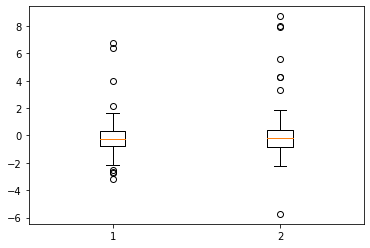

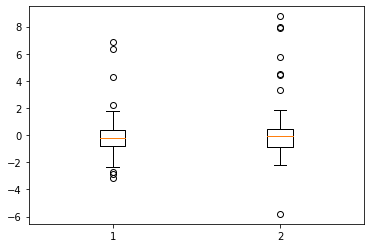

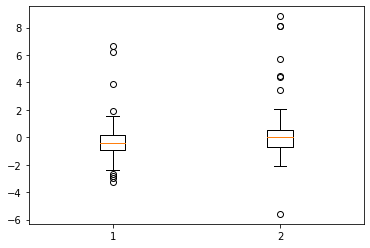

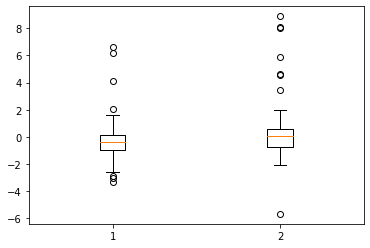

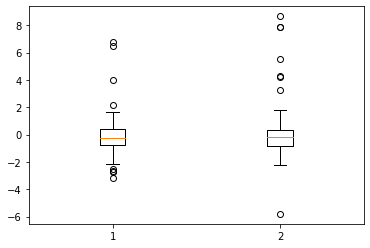

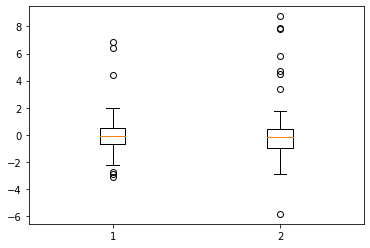

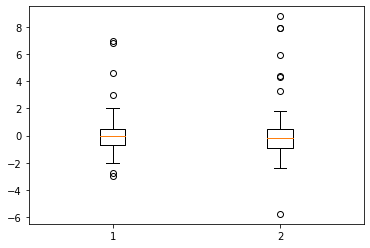

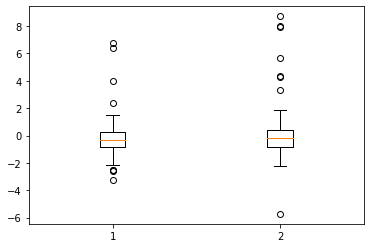

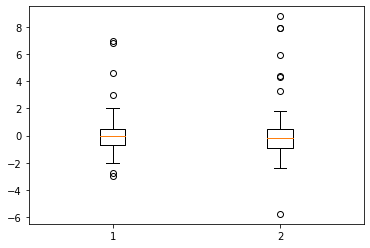

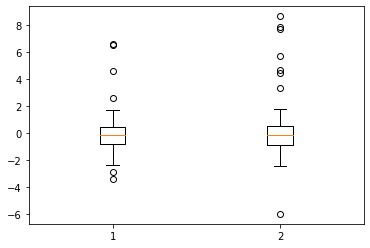

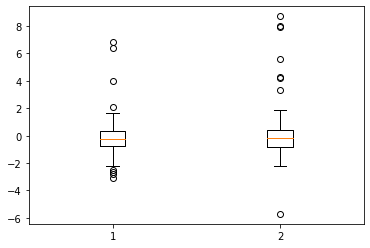

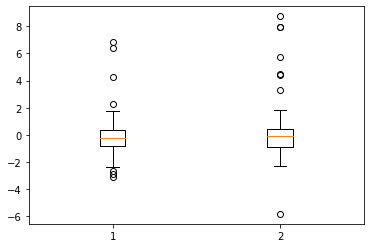

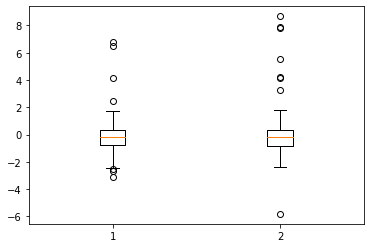

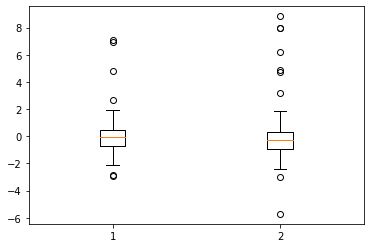

In [34]:
list_cols = list(cols)
for col in list_cols:
    fig7, ax7 = plt.subplots()
    ax7.boxplot(
        [
            (df_predictions_zero[col] - df_predictions_zero["Actual"]),
            (df_predictions_one[col] - df_predictions_one["Actual"]),
        ]
    )
    plt.show()

## Visualising the fairness-accuracy tradeoff

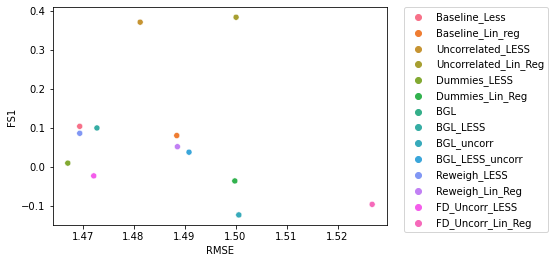

In [35]:
sns.scatterplot(
    data=Results,
    x="Root Mean Squared Error",
    y="Mean Errors difference between groups",
    hue="Models",
)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
plt.xlabel("RMSE")
plt.ylabel("FS1")
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
plt.savefig("FS1_tradeoff_student.jpg", bbox_extra_artists=(lgd,), bbox_inches="tight")

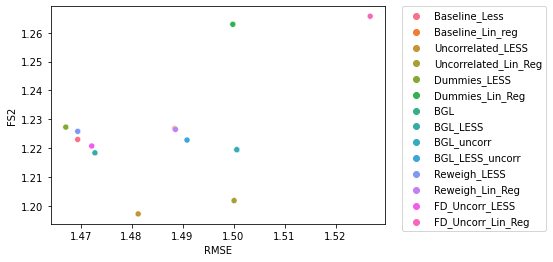

In [36]:
sns.scatterplot(
    data=Results,
    x="Root Mean Squared Error",
    y="Root-mean-squared error ratio between groups",
    hue="Models",
)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
plt.xlabel("RMSE")
plt.ylabel("FS2")
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
plt.savefig("FS2_tradeoff_student.jpg", bbox_extra_artists=(lgd,), bbox_inches="tight")